# Tutorial 13: Derivatives and finite differences

## PHYS 2600

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

## T13.1 - Solving a simple ODE with Euler's method

Let's work through a detailed example of numerical ODE solution, start to finish.  Although there are plenty of pre-built solvers, we'll start from scratch and implement our own solution with Euler's method, so you can understand all the pieces.

Everyone does simple exponential growth, so that's a boring example.  Let's do the following equation instead:

$$
y'(x) = y(x) (1 - \cos(4x))
$$

This isn't much worse to solve than exponential growth, actually: you can still just integrate to find the solution

$$
y(x) = C \exp \left[x-\frac{\sin(4x)}{4} \right].
$$

and if we set the initial condition to $y(0) = 1$, then we simply have $C=1$.  __Run the cell below__ to plot the solution over the range `0 <= x <= 5`.

Text(0, 0.5, 'y(x)')

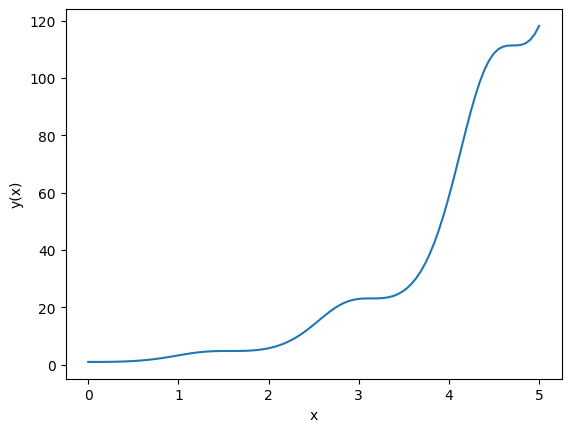

In [2]:
x_exact = np.linspace(0, 5, 100)
y_exact = np.exp(x_exact - 0.25 * np.sin(4 * x_exact))

plt.plot(x_exact, y_exact)
plt.xlabel("x")
plt.ylabel("y(x)")

We'll use the analytic solution to compare with later, but now we need to set up our numerical solver.  We'll work through the steps of the algorithm outlined in lecture.  Given the equation

$$
u'(t) = F(u(t), t)
$$

we do the following:

__(1)__ Discretize time $t \rightarrow \{t_i\}$ and replace $u'(t)$ with the forward-difference $(u_{i+1} - u_i) / \Delta t$.  This gives:

$$
u_{i+1} = u_i + F(u_i, t_i)\ \Delta t
$$

__(2)__ Iterate over the range of all $\{t_i\}$, starting at $t_0$.  Accumulate an array or list of results $\{u_i\}$:
  - For each $t_i$, use the discrete equation with $u_i$ to find $u_{i+1}$.

__(3)__ Return the result for $\{u_i\}$, which is a discrete approximation to the solution $u(t)$ over the discrete interval $\{t_i\}$.

Let's begin with the first step.  __Write the discrete approximation__ to $y'(x) = y(x) (1 - \cos(4x))$ in the cell below, in the form $y_{i+1} = ...$.

Following the formula written above $F(y_i, x_i) = y_i (1 - \cos(4x_i))$, so

$$
y_{i+1} = y_i + y_i(1 - \cos(4x_i)) \Delta x.
$$

### Part A: Set up the equation

Since we'll have to evaluate this equation a lot, __fill out the function `euler_step(xi, yi, dx)` below__, which should __calculate and return $y_{i+1}$__ given the three quantities $x_i$, $y_i$, and the step size $\Delta x$.  Then __run the test cell__ to make sure your function runs and passes the tests!

_(Note: this function takes __individual numbers__, not NumPy arrays!  Because we're solving iteratively, there's no way to calculate the entire array $y_i$ at once; we'll have to go step by step again.)_

In [3]:
def euler_step(xi, yi, dx):
    ### BEGIN SOLUTION
    return yi + yi * (1 - np.cos(4 * xi)) * dx
    ### END SOLUTION
euler_step(0.0, 1.0, 0.1)

np.float64(1.0)

In [4]:
import numpy.testing as npt

npt.assert_allclose(euler_step(0.0, 1.0, 0.1), 1.0)
npt.assert_allclose(euler_step(0.1, 1.0, 0.1), 1.0079, atol=1e-4)

### Part B: Choose your step size and interval

Now we need a discrete set of $x$-values to run our solution over.  Even though we'll just be operating one element at a time, it's still convenient to use NumPy arrays to store everything we're working with here.

Let's take the interval of solution to be $x$ from 0 to 5, matching the plot we made above, and let's begin with a relatively large step size of $\Delta x = 0.1$.  __Create a NumPy array `x_sol`__ which matches these properties.  (Since we want to decide on the step size ourselves, you should probably use `np.arange` instead of `np.linspace`.)

Then, __create a second array `y_sol`__ which should have the following properties:

- It should be the same length as `x_sol`;
- All of the entries in `y_sol` should be 0.0;
- Except for the _first_ entry, which you should set to the initial value $y(0) = 1.0$.


In [5]:
### BEGIN SOLUTION
x_sol = np.linspace(0, 5.1, 51)
y_sol = np.zeros_like(x_sol)
y_sol[0] = 1.0
### END SOLUTION

In [6]:
assert len(x_sol) == 51
assert len(y_sol) == 51
assert abs(y_sol[0] - 1.0) < 1e-8
assert abs(np.sum(y_sol) - 1.0) < 1e-8

### Part C: Find the solution

Now that we have everything set up, we just need to repeatedly step forward from $i=0$.  __Write some code below to fill `y_sol` with the solution__, using `euler_step` from above.  

Since we have to step through an array one entry at a time, we should use a `for` loop!  In each iteration of the loop, you should compute the step for one value of `i`, and then store the result to `y_sol[i+1]`.

_(Hint: this is a variation of the accumulator pattern; since we're using an array initialized to zero, we don't have to append when we accumulate, we just change the value of the `i+1`-th entry.)_

In [7]:
### BEGIN SOLUTION
for i in range(0, len(x_sol) - 1):
    dx = (
        x_sol[1] - x_sol[0]
    )  ## Better to take from x_sol, in case we go back and change dx!
    y_sol[i + 1] = euler_step(xi=x_sol[i], yi=y_sol[i], dx=dx)
### END SOLUTION

Now let's have a look at what we got!  I've repeated the plot of the exact solution below: __add `y_sol` to the plot to see how it compares.__  (Make sure to use the `label=` argument, and label the plot of `y_sol` as "Euler".  The `plt.legend()` command will then read the labels and give you a nice legend telling you which curve is which.)

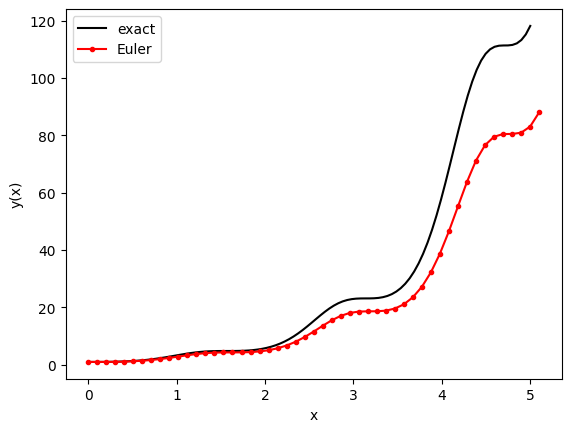

In [8]:
plt.plot(x_exact, y_exact, color="k", label="exact")
plt.xlabel("x")
plt.ylabel("y(x)")

### BEGIN SOLUTION
plt.plot(x_sol, y_sol, color="r", marker=".", label="Euler")
### END SOLUTION

plt.legend()

Not bad; we captured the overall shape of the solution pretty well.  But the two curves are getting further apart as $t$ increases!  This is characteristic of iterative solutions like this.  The error of a single step is proportional to the step size, but the error in $y(5)$ is __cumulative__, since it depends on the results of all 50 previous steps!

### Part D: Exploring convergence

Short of changing methods, we can always try to get a better answer from our existing algorithm just by reducing the step size $\Delta x$.  But if we want to compare multiple step sizes, we'll have to do lots of copy-pasting to keep multiple solutions at once.  

Instead, let's just collect our code from above into a function.  __Copy in and modify your code from step 3 to implement the function `euler_solve(dx)` below__, which should return the tuple of arrays `(x_sol, y_sol)` for any choice of step size `dx`.  For this simple example we won't bother letting the interval or initial conditions vary.



In [9]:
def euler_solve(dx):
    """
    Solve the example differential equation using Euler's method,
    for the given step size dx.

    x-interval is fixed to (0,5), initial condition is y(0)=1.

    Arguments:
    ----
    * dx: step size to use over the interval (0,5).

    Returns:
    ----
    * x_sol, y_sol: arrays containing the discretized interval {x_i} and the solution {y_i}.
    """

    ### BEGIN SOLUTION
    # Set up initial arrays and conditions
    x_sol = np.arange(0, 5.0 + dx, dx)
    y_sol = np.zeros_like(x_sol)
    y_sol[0] = 1.0

    # Solve
    for i in range(0, len(x_sol) - 1):
        y_sol[i + 1] = euler_step(xi=x_sol[i], yi=y_sol[i], dx=dx)

    # Return
    return x_sol, y_sol
    ### END SOLUTION

Now it's easy to iterate over a few different values of `dx`, and plot each of them.  I've set up a list of `dx` values to test, and plotted the exact solution for you again.  __Fill in the code in the `for` loop to plot each solution curve for the `dx` values in `dx_list`.__  

_(Hint: don't forget to give a `label` string in the loop, so that you can tell which is which when you run `plt.legend()` at the end!)_

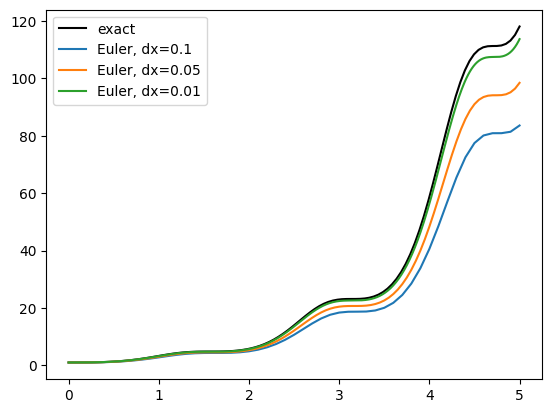

In [10]:
dx_list = (0.1, 0.05, 0.01)
plt.plot(x_exact, y_exact, color="k", label="exact")

for dx in dx_list:
    x_sol_dx, y_sol_dx = euler_solve(dx)
    label = f"Euler, dx={dx:g}"
    plt.plot(x_sol_dx, y_sol_dx, label=label)

plt.legend()

## Uncomment these lines to zoom in!
# plt.xlim(0,2)
# plt.ylim(0,6)

So `dx=0.01` is already a vast improvement; if we wanted it to agree perfectly by eye with the exact solution (black curve), we can probably guess that going down to `dx=0.001` would be more than sufficient.  If we wanted to be more serious about it, we could plot the value of $y(5)$ against the step size `dx`.  __Run the cell below__ to see the step-size dependence of your solution!

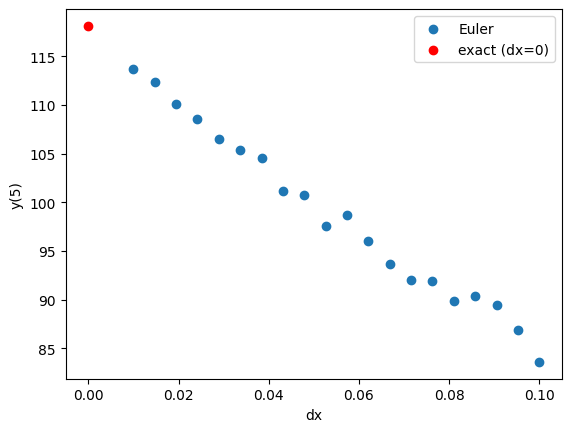

In [11]:
y_final_list = []
y5_exact = 118.127398  # y(5) from exact solution

dx_list_2 = np.linspace(0.01, 0.1, 20)

for dx in dx_list_2:
    x_sol_dx, y_sol_dx = euler_solve(dx)
    y_final_list.append(y_sol_dx[-1])

plt.scatter(dx_list_2, y_final_list, label="Euler")
plt.scatter(0, y5_exact, color="red", label="exact (dx=0)")
plt.xlabel("dx")
plt.ylabel("y(5)")
plt.legend()

It's pretty obvious from this plot that up to some small variations, the accumulated error in $y(5)$ is linear in `dx`.  So __even if we didn't know the exact solution__, we can get close by tuning `dx` to be small, and we can get even closer by _extrapolating_ `dx` to zero.  (How to actually do the extrapolation is a story for another day...)

### Bonus part E (optional challenge): other solution methods

As I mentioned in class, there are several implementations of more accurate ODE solution methods readily available in Python modules.  As always, a good place to start looking is the SciPy module, where you'll find ODE solvers in the submodule [scipy.integrate](https://docs.scipy.org/doc/scipy/reference/integrate.html).

A common interface to several underlying methods is provided by the `scipy.integrate.solve_ivp` function.  Uncomment and run the cell below to bring up its documentation string.

In [12]:
import scipy.integrate as si

# si.solve_ivp?

Use `si.solve_ivp` with the default method, `'RK45'` (fourth-order Runge-Kutta), to solve the same equation we've been studying with Euler's method.

_(Note: the_ `solve_ivp` _function returns something called a "bunch object".  What that means is that it has all of the results you want stored as __properties__, which we access with dot notation.  For example, if we call_ `solution = si.solve_ivp(...)`, _then `solution.t` and `solution.y` are the arrays of points for the independent and dependent variable.)_

_(Another note: by default_ `si.solve_ivp` _won't return very many points in the interval where it's solving.  If you want to make a good plot, give the option_ `t_eval=np.linspace(0,5,100)` _to produce a more continuous set of points suitable for plotting.)_

In [13]:
### BEGIN SOLUTION
# scipy.integrate wants a function, not an array.
def ode_RHS(x, y):
    return y * (1 - np.cos(4 * x))


solution = si.solve_ivp(
    lambda x, y: y * (1 - np.cos(4 * x)),
    (0.0, 5.0),
    [1.0],
    t_eval=np.linspace(0, 5, 100),
)
solution = si.solve_ivp(ode_RHS, (0.0, 5.0), [1.0], t_eval=np.linspace(0, 5, 100))
### END SOLUTION

__Important note:__ you'll notice from the documentation that `solve_ivp` has no option to choose the step size `dx`!  Instead, it just takes a tuple `(xi, xf)` defining the solution interval, and the arguments `atol` (absolute tolerance) and `rtol` (relative tolerance) that specify the accuracy we want our solution to have.  The appropriate step size is then calculated from the required error tolerance and the known error formulas for the algorithm used.

This is, of course, a much more sophisticated approach than just setting `dx` and hoping for the best as we were doing above!  But working with step size was still a good exercise; even if we can do better for simple one-dimensional ODEs, there are lots of interesting systems (like solving Maxwell's equations) where it's much harder to prove any strict error bound, and we would be back to controlling step size directly.

__Make a plot to compare your Runge-Kutta result to the exact solution__.  Again, if the plot looks unexpectedly blocky, go back above and try adjusting the optional `t_eval=...` option for `solve_ivp`.

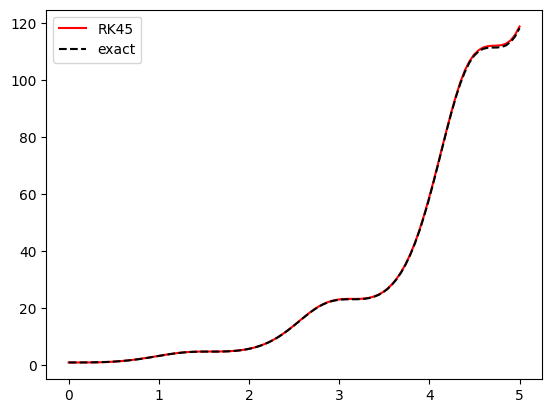

In [14]:
### BEGIN SOLUTION
plt.plot(solution.t, solution.y[0], label="RK45", color="r")
plt.plot(x_exact, y_exact, color="k", label="exact", ls="--")
plt.legend()
### END SOLUTION